(20000, 1, 28, 28) float32
(20000,) int64
(2000, 1, 28, 28) float32


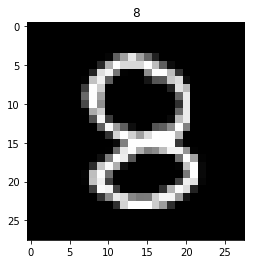

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
with np.load('prediction-challenge-01-data.npz') as fh:
    data_x = fh['data_x']
    data_y = fh['data_y']
    test_x = fh['test_x']

# TRAINING DATA: INPUT (x) AND OUTPUT (y)
# 1. INDEX: IMAGE SERIAL NUMBER
# 2. INDEX: COLOR CHANNEL
# 3/4. INDEX: PIXEL VALUE
print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)

# TEST DATA: INPUT (x) ONLY
print(test_x.shape, test_x.dtype)

plt.imshow(data_x[0, 0], cmap='gray')
plt.title(data_y[0])
plt.show()

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

In [5]:
class digits(torch.utils.data.Dataset):
    def __init__(self, fp, transform=trans, dset="train"):
        VAL_SIIZE = 5000
        self.transform = transform
        with np.load(fp) as fh:
            if dset=="train":
                self.data_x = fh['data_x'][5000:]
                self.data_y = fh['data_y'][5000:]
                assert len(self.data_x) == len(self.data_y)
            elif dset=="val":
                self.data_x = fh['data_x'][:5000]
                self.data_y = fh['data_y'][:5000]
                assert len(self.data_x) == len(self.data_y)
            elif dset=="test":
                self.data_x = fh['test_x']
                self.data_y = None

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, i):
        image = self.data_x[i]#np.squeeze(self.data_x[i],0)
        #print(image.shape)
        if self.data_y is None:
            image = self.transform(image)
            return image
        label = self.data_y[i]
        if self.transform:
            image = self.transform(image)
        sample = (image, label)
        return sample

In [6]:
fp = 'prediction-challenge-01-data.npz'
train_dataset = digits(fp,trans,dset="train")
val_dataset = digits(fp,trans,dset="val")
test_dataset = digits(fp,trans,dset="test")

In [7]:
train_dataset[0]

(tensor([[[  -0.5000,   -0.5000,   -0.5000,   -0.5000,   -0.5000,
             -0.5000,   -0.5000,   -0.5000,   -0.5000,   -0.5000,
             -0.5000,   -0.5000,   -0.5000,   -0.5000,   -0.5000,
             -0.5000,   -0.5000,   -0.5000,   -0.5000,   -0.5000,
             -0.5000,   -0.5000,   -0.5000,   -0.5000,   -0.5000,
             -0.5000,   -0.5000,   -0.5000]],
 
         [[   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
              0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
              0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
              0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
              0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
              0.0000,    0.0000,    0.0000]],
 
         [[   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
              0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
              0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
              0.0000,    0.0000,    0.0000,   

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

In [9]:
model = Net()

In [10]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [12]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128, 
                                           shuffle=True,
                                           **kwargs)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=128,
                                          shuffle=False,
                                          **kwargs)

In [19]:
for batch_idx, (data,target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        print(data.numpy().shape)
        data, target = Variable(data), Variable(target)
        break

(128, 28, 1, 28)


In [14]:
from torch.autograd import Variable

def train(epoch):
    model.train()
    
    for batch_idx, (data,target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        
        output = model(data)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [282]:
def evaluate():
    model.eval()
    val_loss = 0
    correct = 0
    for data, target in val_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        val_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    val_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f} (Best: {:.4f}), Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, best_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))

In [280]:
epochs = 100
for epoch in range(1, epochs + 1):
    train(epoch)
    evaluate()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


Train Epoch: 1 [0/15000 (0%)]	Loss: 0.038982
Train Epoch: 1 [6400/15000 (42%)]	Loss: 0.022379
Train Epoch: 1 [12800/15000 (85%)]	Loss: 0.016079
improved

Validation set: Average loss: 0.1450 (Best: 0.1450), Accuracy: 4797/5000 (96%)

Train Epoch: 2 [0/15000 (0%)]	Loss: 0.010970
Train Epoch: 2 [6400/15000 (42%)]	Loss: 0.022706
Train Epoch: 2 [12800/15000 (85%)]	Loss: 0.036210
stagnating

Validation set: Average loss: 0.1452 (Best: 0.1450), Accuracy: 4796/5000 (96%)

Train Epoch: 3 [0/15000 (0%)]	Loss: 0.007703
Train Epoch: 3 [6400/15000 (42%)]	Loss: 0.012720
Train Epoch: 3 [12800/15000 (85%)]	Loss: 0.018895
improved

Validation set: Average loss: 0.1447 (Best: 0.1447), Accuracy: 4799/5000 (96%)

Train Epoch: 4 [0/15000 (0%)]	Loss: 0.020529
Train Epoch: 4 [6400/15000 (42%)]	Loss: 0.016793
Train Epoch: 4 [12800/15000 (85%)]	Loss: 0.014706
stagnating

Validation set: Average loss: 0.1450 (Best: 0.1447), Accuracy: 4797/5000 (96%)

Train Epoch: 5 [0/15000 (0%)]	Loss: 0.023842
Train Epoch: 5 

stagnating

Validation set: Average loss: 0.1443 (Best: 0.1441), Accuracy: 4800/5000 (96%)

Train Epoch: 36 [0/15000 (0%)]	Loss: 0.012361
Train Epoch: 36 [6400/15000 (42%)]	Loss: 0.011271
Train Epoch: 36 [12800/15000 (85%)]	Loss: 0.010709
improved

Validation set: Average loss: 0.1441 (Best: 0.1441), Accuracy: 4800/5000 (96%)

Train Epoch: 37 [0/15000 (0%)]	Loss: 0.021048
Train Epoch: 37 [6400/15000 (42%)]	Loss: 0.019899
Train Epoch: 37 [12800/15000 (85%)]	Loss: 0.015138
improved

Validation set: Average loss: 0.1440 (Best: 0.1440), Accuracy: 4801/5000 (96%)

Train Epoch: 38 [0/15000 (0%)]	Loss: 0.018903
Train Epoch: 38 [6400/15000 (42%)]	Loss: 0.016521
Train Epoch: 38 [12800/15000 (85%)]	Loss: 0.007355
stagnating

Validation set: Average loss: 0.1443 (Best: 0.1440), Accuracy: 4800/5000 (96%)

Train Epoch: 39 [0/15000 (0%)]	Loss: 0.012215
Train Epoch: 39 [6400/15000 (42%)]	Loss: 0.010867
Train Epoch: 39 [12800/15000 (85%)]	Loss: 0.008752
stagnating

Validation set: Average loss: 0.1443

Train Epoch: 70 [6400/15000 (42%)]	Loss: 0.010116
Train Epoch: 70 [12800/15000 (85%)]	Loss: 0.012812
stagnating

Validation set: Average loss: 0.1444 (Best: 0.1439), Accuracy: 4799/5000 (96%)

Train Epoch: 71 [0/15000 (0%)]	Loss: 0.018667
Train Epoch: 71 [6400/15000 (42%)]	Loss: 0.010411
Train Epoch: 71 [12800/15000 (85%)]	Loss: 0.018457
stagnating

Validation set: Average loss: 0.1439 (Best: 0.1439), Accuracy: 4803/5000 (96%)

Train Epoch: 72 [0/15000 (0%)]	Loss: 0.011327
Train Epoch: 72 [6400/15000 (42%)]	Loss: 0.012696
Train Epoch: 72 [12800/15000 (85%)]	Loss: 0.018576
stagnating

Validation set: Average loss: 0.1441 (Best: 0.1439), Accuracy: 4801/5000 (96%)

Train Epoch: 73 [0/15000 (0%)]	Loss: 0.012279
Train Epoch: 73 [6400/15000 (42%)]	Loss: 0.007097
Train Epoch: 73 [12800/15000 (85%)]	Loss: 0.014666
stagnating

Validation set: Average loss: 0.1441 (Best: 0.1439), Accuracy: 4801/5000 (96%)

Train Epoch: 74 [0/15000 (0%)]	Loss: 0.017924
Train Epoch: 74 [6400/15000 (42%)]	Loss: 0.0

In [283]:
def pred():
    model.eval()
    result = np.zeros((len(test_dataset)))
    for i,data in enumerate(test_dataset):
        data = Variable(data, volatile=True)
        output = model(data)
        pred_class = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        result[i] = pred_class
    return result

In [284]:
prediction = pred()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [285]:
prediction

array([ 9.,  7.,  3., ...,  4.,  4.,  0.])

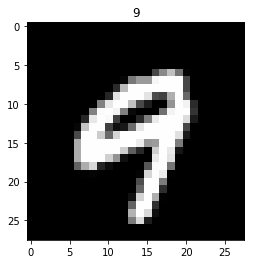

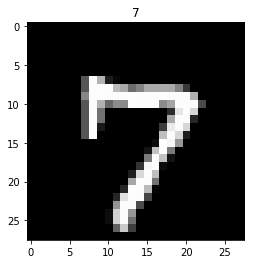

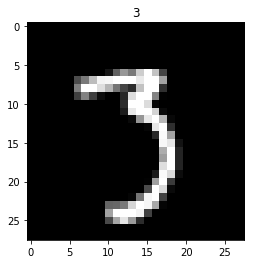

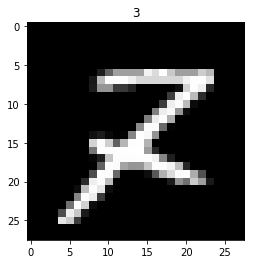

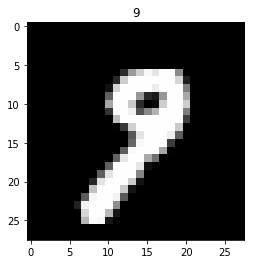

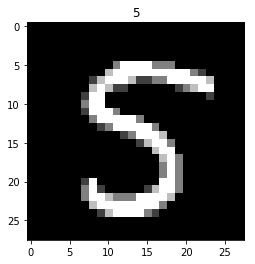

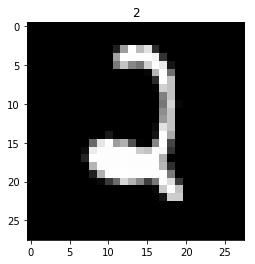

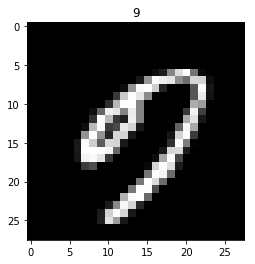

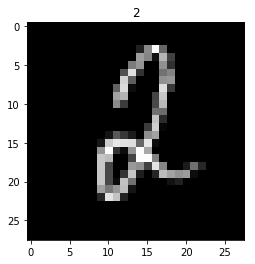

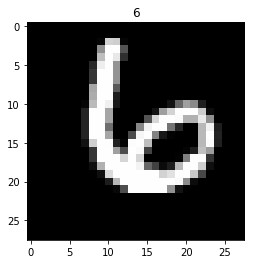

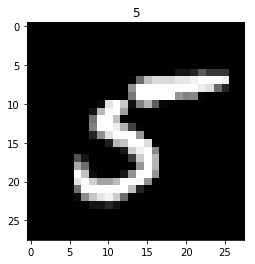

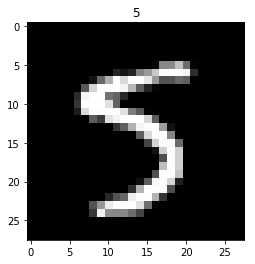

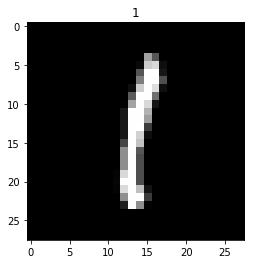

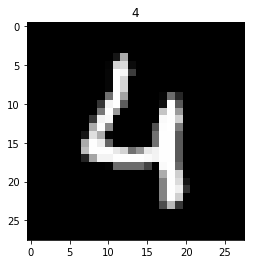

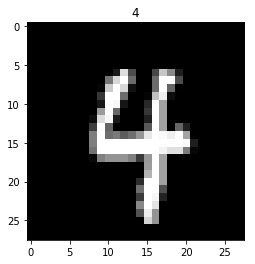

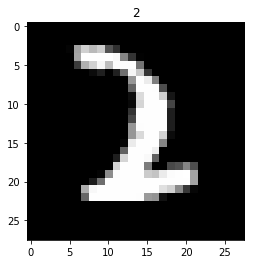

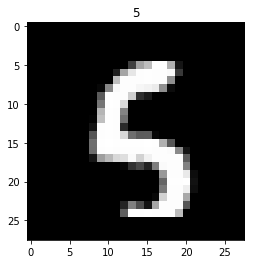

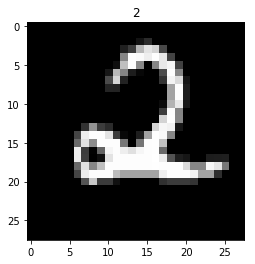

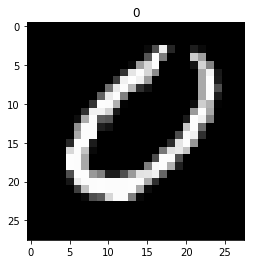

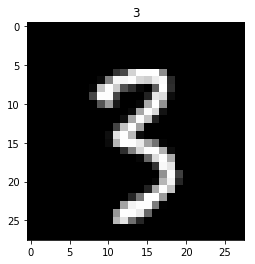

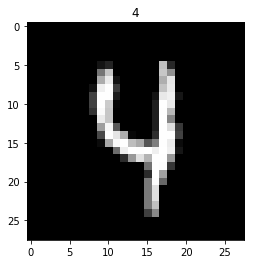

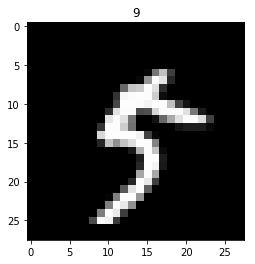

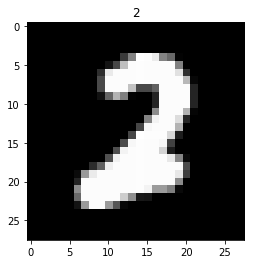

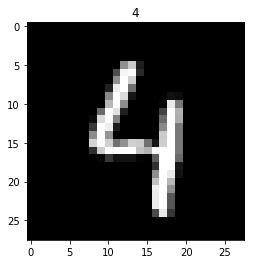

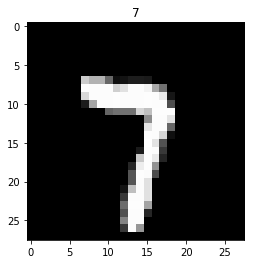

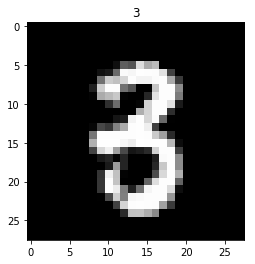

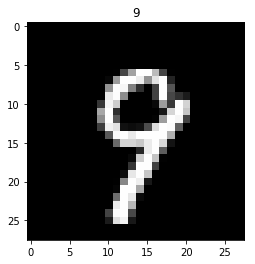

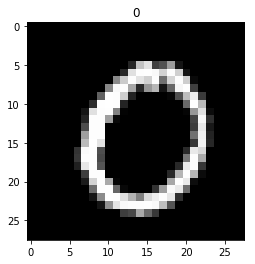

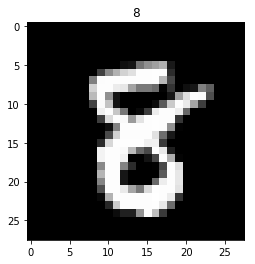

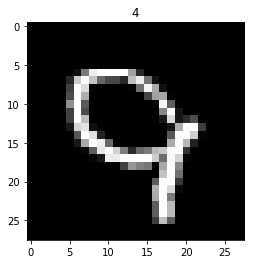

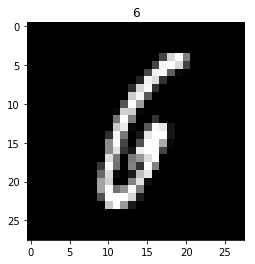

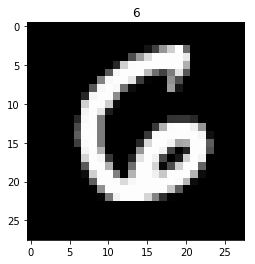

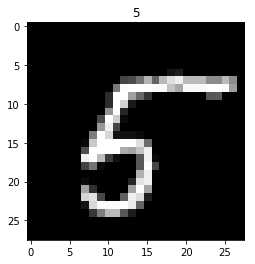

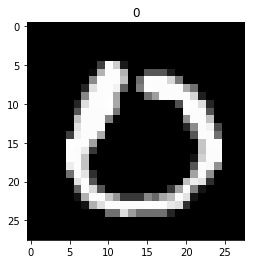

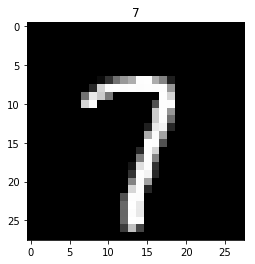

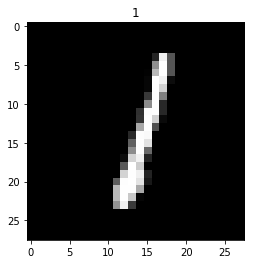

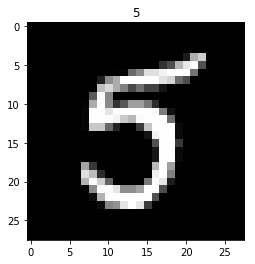

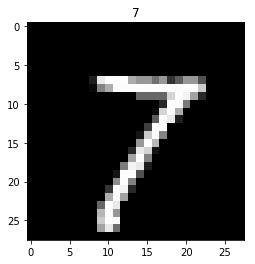

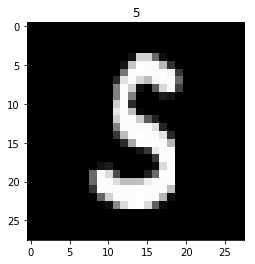

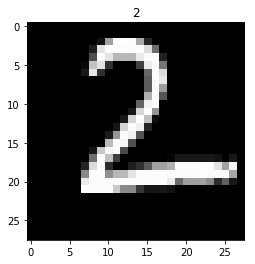

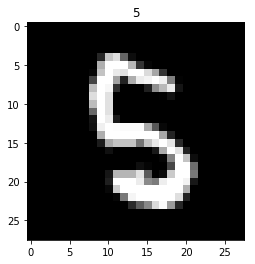

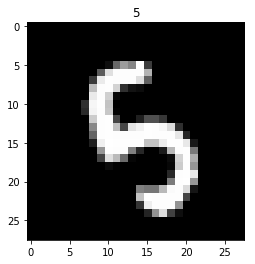

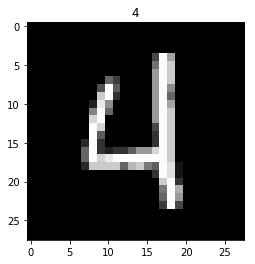

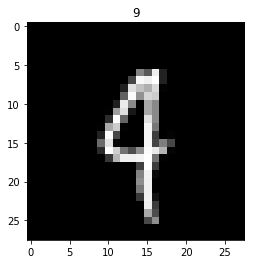

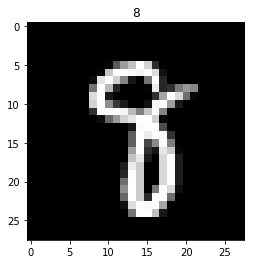

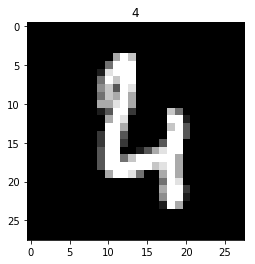

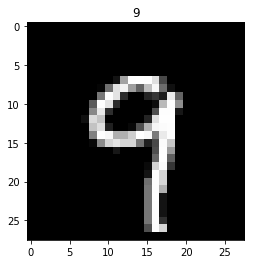

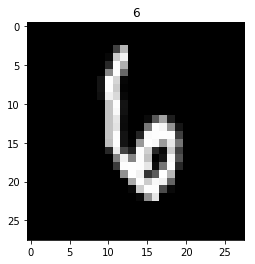

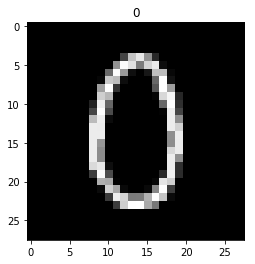

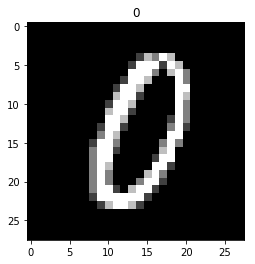

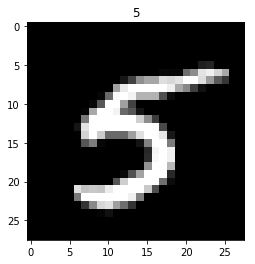

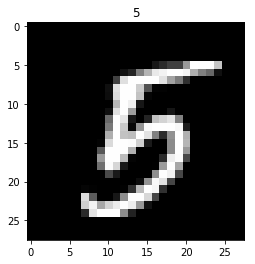

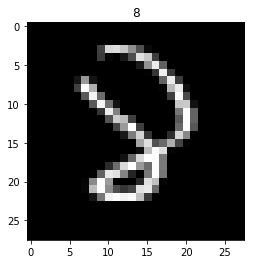

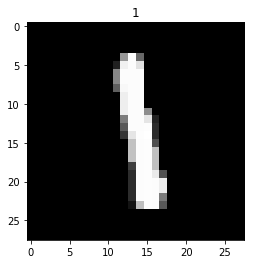

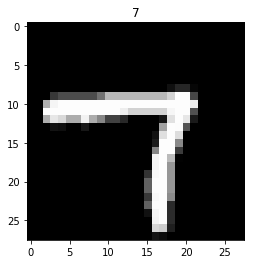

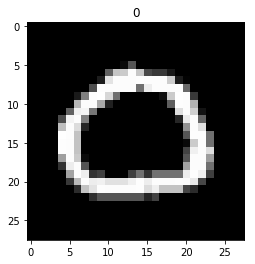

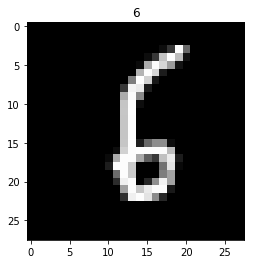

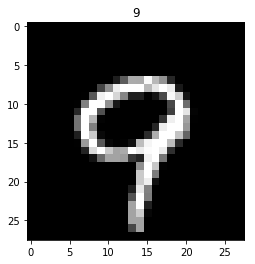

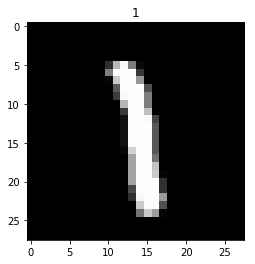

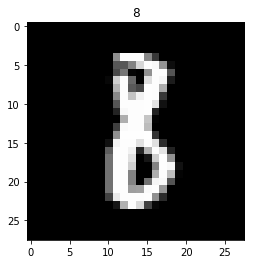

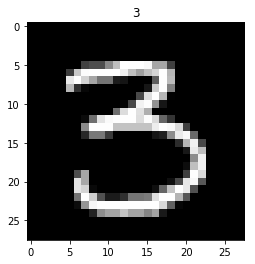

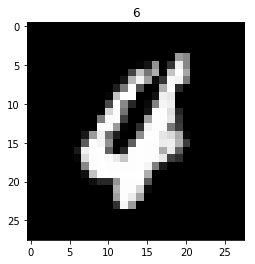

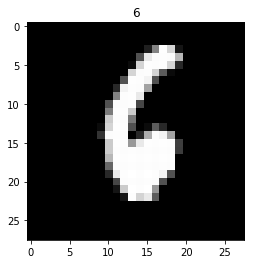

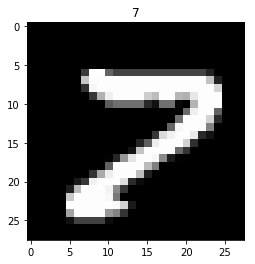

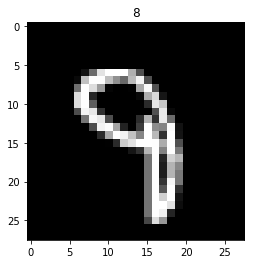

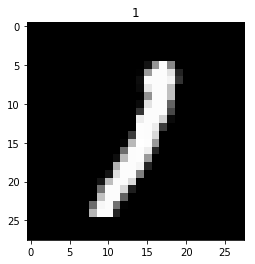

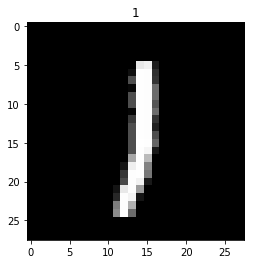

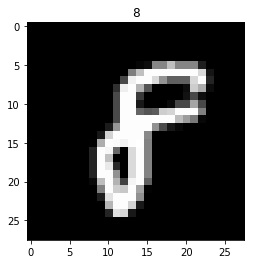

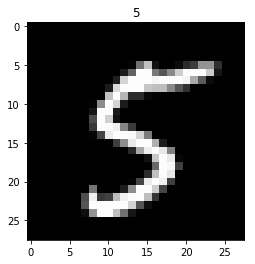

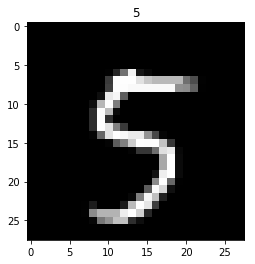

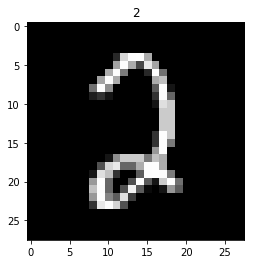

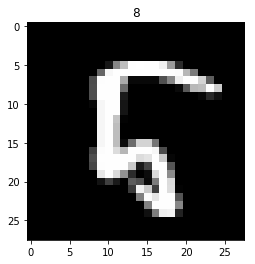

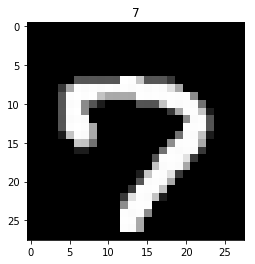

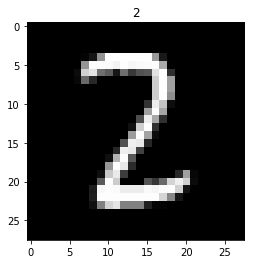

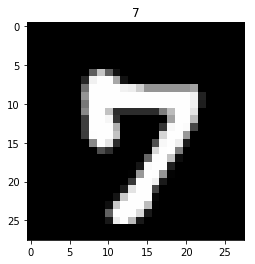

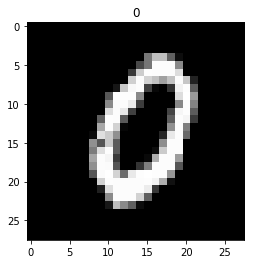

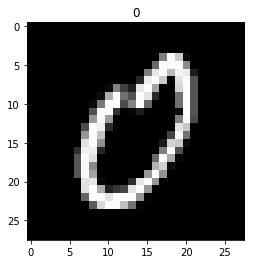

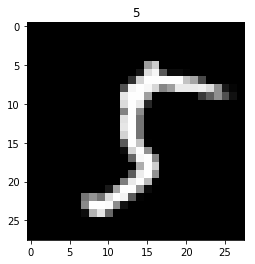

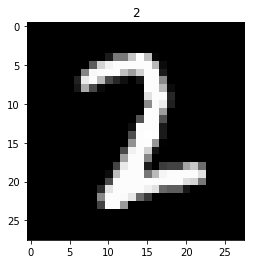

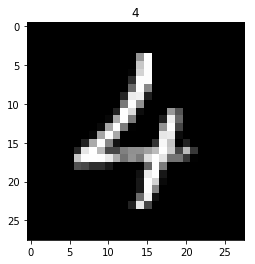

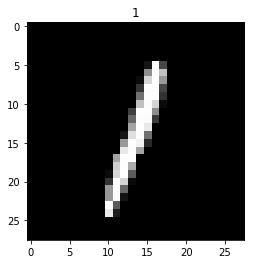

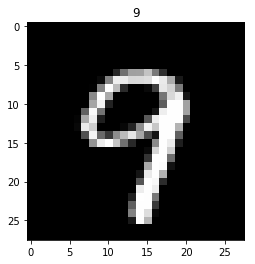

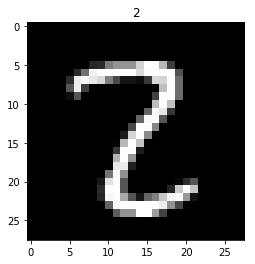

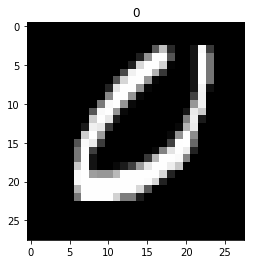

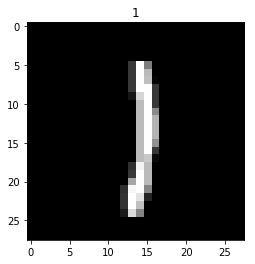

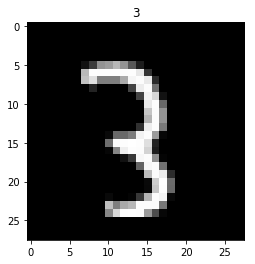

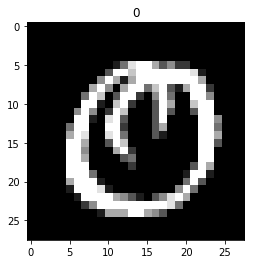

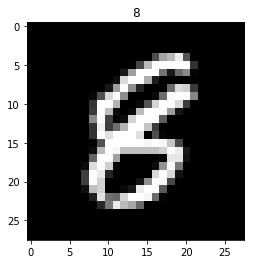

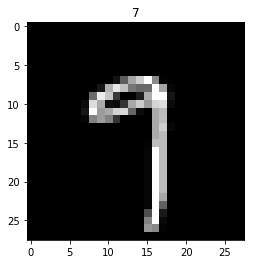

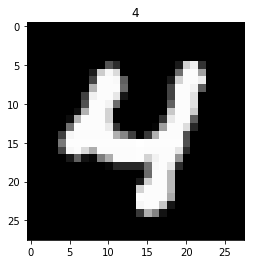

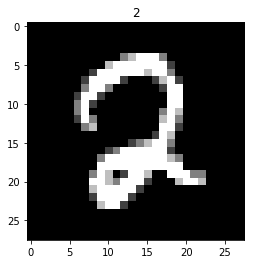

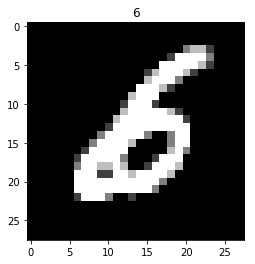

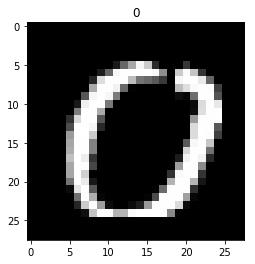

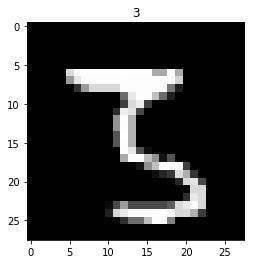

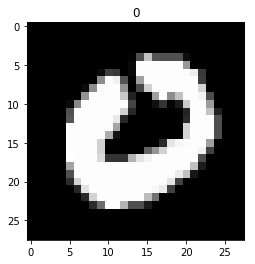

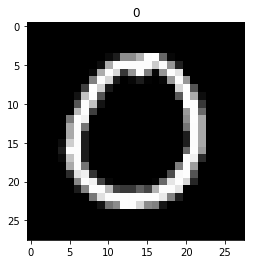

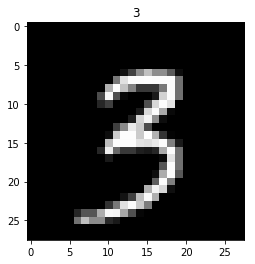

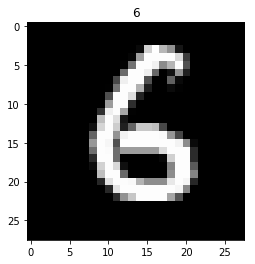

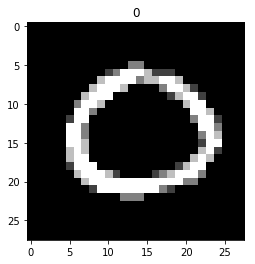

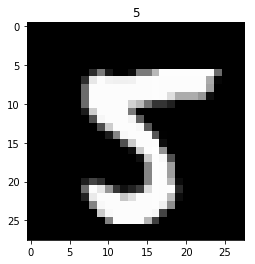

In [289]:
import time
for i in range(100):
    p = test_x[i,0]
    plt.imshow(p, cmap='gray')
    plt.title(int(prediction[i]))
    plt.show()

In [247]:
# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert prediction.ndim == 1
assert prediction.shape[0] == 2000

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('prediction.npy', prediction)

In [290]:
np.histogram(prediction)

(array([208, 200, 195, 211, 215, 191, 197, 201, 194, 188]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]))

In [275]:
def evaluate_best():
    best_model.eval()
    global best_model
    global best_loss
    
    val_loss = 0
    correct = 0
    for data, target in val_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = best_model(data)
        val_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    val_loss /= len(val_loader.dataset)
    #if val_loss < best_loss:
    #    best_model = model
    #    best_loss = val_loss
    #    print("improved")
    #else: 
    #    print("stagnating")
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))

<ipython-input-275-e2e181309deb>:3: SyntaxWarning: name 'best_model' is used prior to global declaration
  global best_model


In [291]:
evaluate_best()


Validation set: Average loss: 0.1446, Accuracy: 4801/5000 (96%)



/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  
